In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import splrep, splev
from scipy.stats import  expon, uniform, kstest, rv_continuous, ks_2samp, cramervonmises_2samp, wasserstein_distance, genpareto
from typing import Callable
import pandas as pd
from collections import defaultdict
from random import choices

In [4]:
def get_ams(time: np.ndarray, value: np.ndarray) -> np.ndarray:
    """Extract annual maximums from timeseries."""
    year = np.floor(time / 365)
    ams = []
    for y in np.unique(year):
        ams.append(value[year == y].max())
    return np.array(ams)

In [56]:
def sst(storm_catalog: list, spatial_sampler: rv_continuous, watershed_function: Callable, original_sampler: rv_continuous = None) -> list:
    new_locs = spatial_sampler.rvs(size=len(storm_catalog))
    if original_sampler is not None:  # account for importance sampling
        multipliers = original_sampler.pdf(new_locs) / spatial_sampler.pdf(new_locs)
    else:
        multipliers = [1] * len(new_locs)
    qs = storm_catalog * watershed_function(new_locs) * multipliers
    return qs

Helper Functions

Define a watershed function (stand-in for running HMS).  This converts precipitation to discharge.

In [6]:
y = [6000, 7000, 5500, 8000, 4000, 3000, 3500, 2500, 4000, 2000, 1000, 500, 1000]  # Unit discharge
n = len(y)
x = np.linspace(0, 100, n)  # watershed spatial component
tck = splrep(x, y)
watershed = lambda x: splev(x, tck, ext=1)

Text(0, 0.5, 'Unit Discharge (cfs/in)')

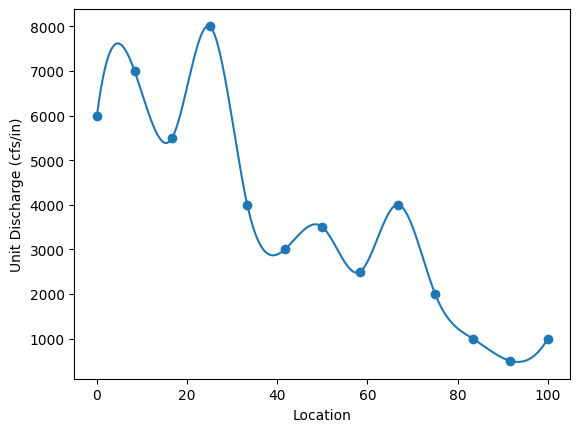

In [7]:
fig, ax = plt.subplots()
ax.scatter(x, y)
xfit = np.linspace(0, 100, 1000)
yfit = watershed(xfit)
ax.plot(xfit, yfit)
ax.set_xlabel("Location")
ax.set_ylabel("Unit Discharge (cfs/in)")

Define hydrologic region model

In [30]:
storm_rate = 240  # 24 storms per year
storm_rate /= 365 # storms per day
arriver = expon(scale = 1 / storm_rate)
precip = genpareto(c=0.5, loc=1000, scale=1000)
locs = uniform(0, 1000)
baseflow = 500

Approximate long-term flood series

In [31]:
record_length = 1000  # years
interevents = arriver.rvs(int(record_length * storm_rate * 365 * 1.2))  # Approximate with 20% error
arrivals = interevents.cumsum()
arrivals = arrivals[arrivals < (record_length * 365)]
n = len(arrivals)
p = precip.rvs(size=n)
l = locs.rvs(size=n)
qs = p * splev(l, tck, ext=1)
# qs[qs == 0] = baseflow
ams = get_ams(arrivals, qs)

Text(0, 0.5, 'Cumulative Probability')

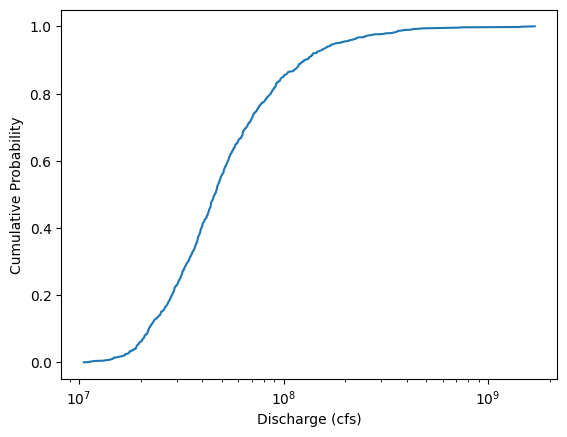

In [32]:
fig, ax = plt.subplots()
q_sort = np.sort(ams)
ratio = np.linspace(0, 1, len(q_sort))
ax.plot(q_sort, ratio)
ax.set_xscale("log")
ax.set_xlabel("Discharge (cfs)")
ax.set_ylabel("Cumulative Probability")

Create limited observation series (storm catalog)

In [34]:
observed_record_length = 30  # years
p_obs = p[arrivals < (observed_record_length * 365)]
t_obs = arrivals[arrivals < (observed_record_length * 365)]
lambda_obs = len(t_obs) / observed_record_length  # events per year

Create storm catalog with subset of data

In [51]:
lambda_ = 24  # events per year
storm_catalog = np.sort(np.array(p_obs))[-lambda_*observed_record_length:]

SST

In [57]:
epochs = 100
simulated_length = 100
sst_qs = []
spatial_sampler = uniform(0, 100)
event_times = np.cumsum([365 / lambda_] * lambda_ * simulated_length)

for e in range(epochs):
    sampled_storms = np.random.choice(storm_catalog, lambda_ * simulated_length)
    sampled_qs = sst(sampled_storms, spatial_sampler, watershed, locs)
    sampled_ams = get_ams(event_times, sampled_qs)
    sst_qs.extend(sampled_ams)

0.0


Text(0, 0.5, 'Cumulative Probability')

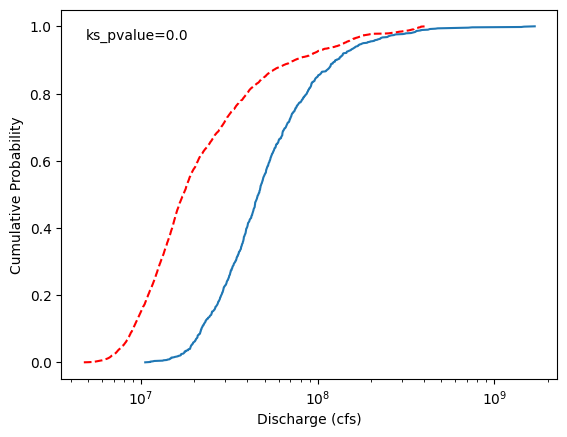

In [58]:
ks = ks_2samp(sst_qs, qs)
print(ks.pvalue)

fig, ax = plt.subplots()
# Original data
q_sort = np.sort(ams)
ratio = np.linspace(0, 1, len(q_sort))
ax.plot(q_sort, ratio)
# SST data
sst_qs_sort = np.sort(sst_qs)
ratio = np.linspace(0, 1, len(sst_qs_sort))
ax.plot(sst_qs_sort, ratio, color="r", ls="dashed")
# KS Pvalue
ax.text(0.05, 0.95, f'ks_pvalue={round(ks.pvalue, 5)}', ha='left', va='top', transform = ax.transAxes)
# Format
ax.set_xscale("log")
ax.set_xlabel("Discharge (cfs)")
ax.set_ylabel("Cumulative Probability")